<Figure size 432x288 with 0 Axes>

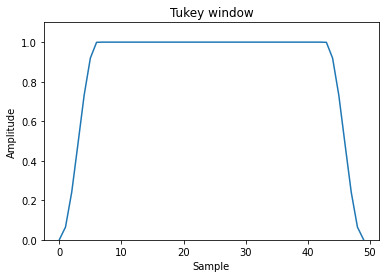

<Figure size 432x288 with 0 Axes>

In [ ]:
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import numpy as np

window = signal.windows.tukey(50, 0.25)
plt.plot(window)
plt.title("Tukey window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.ylim([0, 1.1])

plt.figure()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# https://www.tensorflow.org/tutorials/load_data/images # TUTORIAL CNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.11

import os
import pathlib
import pandas as pd
import numpy as np
from pywt import wavedec
import librosa
import random

from scipy.io import wavfile
from scipy.signal import find_peaks
import scipy.fft as fft
from scipy import signal

from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook

import seaborn as sns

import tensorflow as tf #2.9.2 --> 2.11

print(tf.__version__)
if (tf.__version__ == '2.9.2'):
  %pip install --upgrade tensorflow
  print(tf.__version__)


from tensorflow.keras import layers
from tensorflow.keras import models



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.11.0


In [ ]:
datasets_path = '/content/drive/MyDrive/Mestrado/datasets/'

datasets = pd.read_csv(datasets_path + 'datasets.csv')
print(datasets.head())

               fname        label  speed
0  no_strip_70_0.WAV     no-strip     70
1  no_strip_80_0.WAV     no-strip     80
2  no_strip_90_0.WAV     no-strip     90
3    strip6_70_0.WAV   6-cm-strip     70
4    strip6_80_0.WAV   6-cm-strip     80


In [ ]:
print(datasets.label.unique())

[' no-strip' ' 6-cm-strip' ' 14-cm-strip']


**Get duration of all audios**

In [ ]:
for (file) in (datasets.fname):
  path = (datasets_path+file)
  duration = librosa.get_duration(filename=path)

labels = datasets.label.str.strip()
for (index, file) in zip(datasets.index, datasets.fname):
  duration = librosa.get_duration(filename=(datasets_path + file))
  datasets.loc[datasets.index==index,'duration'] = duration

print(datasets.head())

               fname        label  speed   duration
0  no_strip_70_0.WAV     no-strip     70  60.267392
1  no_strip_80_0.WAV     no-strip     80  63.082812
2  no_strip_90_0.WAV     no-strip     90  60.505397
3    strip6_70_0.WAV   6-cm-strip     70  65.329342
4    strip6_80_0.WAV   6-cm-strip     80  63.210522


In [ ]:
min_audio_time = datasets.duration.min()

print(min_audio_time)

60.26739229024943


**Applying Wavelet Transform**

In [ ]:
def apply_sacdm(data, samples_num):
    data_len = len(data)
    size = 1 + int(data_len/samples_num)
    sacdm=[0.0] * size

    inicio = 0
    fim = samples_num
    for k in range(size):
      peaks, _ = find_peaks(data[inicio:fim])
      v = np.array(peaks)
      sacdm[k] = 1.0*len(v)/samples_num
      inicio = fim
      fim = fim + samples_num

    return np.array(sacdm)

In [ ]:
def split_data_equaly(data, samplerate, split_time_in_sec=2):
  data_length = len(data)
  data_time_in_sec = data_length/samplerate

  splitted_data_sample_count = int((data_length * split_time_in_sec) / data_time_in_sec)
  splitted_data = []

  split_count = int(data_time_in_sec/split_time_in_sec)
  splitted_data.append(data[0 : splitted_data_sample_count])
  for index in range(1, split_count):
    splitted = data[index * splitted_data_sample_count + 1 : index * splitted_data_sample_count + splitted_data_sample_count + 1]

    splitted_data.append(splitted)

  return splitted_data

In [ ]:
def read_wav(filename):
  samplerate, data = wavfile.read(datasets_path + filename)

  return samplerate, data

In [ ]:
class MasterData():
  def __init__(self, data, samplerate, name, label, speed, index):
    # self.data = self.normalize_data(data)
    self.data = data
    self.samplerate = samplerate
    self.name = name
    self.label = label.strip()
    self.speed = speed
    self.index = index
    self.tf_data = tf.data.Dataset.from_tensor_slices(data)
    # self.splitted_data = None

  def save_file(self, filepath):
    if not os.path.exists(filepath):
      os.mkdir(filepath)
      print("Directory " , filepath ,  " Created ")
    file_name = filepath + self.name

    wavfile.write(file_name, self.samplerate, self.data.astype(np.int16))

  def normalize_data(self, data):
    return minmax_scale(data, feature_range=(0,1))

  def to_csv(self, filepath):

    if not os.path.exists(filepath):
      os.mkdir(filepath)
      print("Directory " , filepath ,  " Created ")

    if not os.path.exists(filepath + self.label.strip()):
      os.mkdir(filepath + self.label.strip())
      print("Directory " , filepath + self.label.strip(),  " Created ")
    file_name = filepath + self.label.strip() + '/' + self.label.strip()
    file_name_concat = file_name + '_' + str(self.index) + '_' + str(self.speed) +'.csv'

    np.savetxt(file_name_concat, self.data, delimiter=',', fmt='%f')

In [ ]:
all_original_data = []
i = 0
for index, row in datasets.iterrows():
  samplerate, data = read_wav(row.fname)
  audio_binary = tf.io.read_file(datasets_path+row.fname)

  for splitted_data in split_data_equaly(data, samplerate, split_time_in_sec=1):
    sacdm_data = apply_sacdm(splitted_data, 30)
    obj = MasterData(sacdm_data, samplerate, 'sacdm_original_' + row.fname, row.label, row.speed, i)
    i = i+1
    all_original_data.append(obj)

<ipython-input-9-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5315628 bytes, expected 10902150 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-9-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5563948 bytes, expected 11242770 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-9-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5336620 bytes, expected 10878794 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-9-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5762092 bytes, expected 11688742 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipython-input-9-8e139b72dcb4>:2: WavFileWarning: Reached EOF prematurely; finished at 5575212 bytes, expected 11351290 bytes from header.
  samplerate, data = wavfile.read(datasets_path + filename)
<ipyt

In [ ]:
def get_spectrogram(waveform, audio_frequency=44100):
  # Zero-padding for an audio waveform with less than 16,000 samples.

  input_len = audio_frequency
  waveform = waveform[:input_len]
  zero_padding = np.zeros(
      audio_frequency - waveform.shape[0],
      dtype=float)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  equal_length_tf = tf.constant(equal_length)
  spectrogram = tf.signal.stft(
      equal_length_tf, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Let's plot a few wave forms

0.26666666666666666
0.26666666666666666
0.26666666666666666
0.23333333333333334
0.26666666666666666
0.23333333333333334
0.23333333333333334
0.26666666666666666
0.26666666666666666


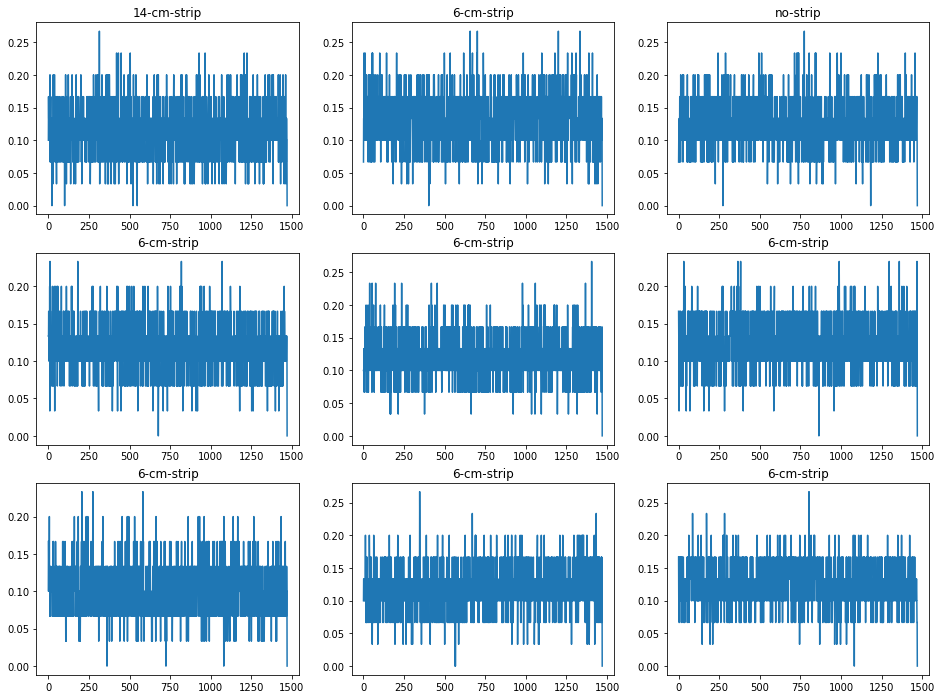

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

# Get "n" random items to plot
for i, audio in enumerate(random.choices(all_original_data, k=n)):
  # audio_as_float = to_float(audio)
  print(np.max(audio.data))
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # print(audio.numpy().astype(np.string_))
  ax.plot(audio.data)
  # ax.set_yticks(np.arange(0, 0.5, 0.1))
  # ax.set_yticks(np.arange(-12, 12, 2))
  # sacdm_audio = apply_sacdm(audio.numpy(), 1000)
  # ax.plot(sacdm_audio)
  # label = audio.label.numpy().decode('utf-8')
  ax.set_title(audio.label)

# plt.show()


In [ ]:
def get_spectrogram_and_label_id(audio, label):
  # spectrogram = get_spectrogram(audio) #TODO: apenas passando o audio pois o spectrograma sera gerado dps
  spectrogram = audio
  label_id = label#list(labels).index(label)
  # label_id = tf.argmax(label == labels)
  # label_id = tf.constant(list(labels).index(label))
  # print(label, label_id)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = [get_spectrogram_and_label_id(x.data, x.label) for x in all_original_data]

In [ ]:
dataset_csv_path = datasets_path + 'sacdm_original_splitted';
data_dir = pathlib.Path(dataset_csv_path)

labels = list(set(labels))
print(labels)

['no-strip', '14-cm-strip', '6-cm-strip']


In [ ]:
# filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
# filenames = tf.random.shuffle(filenames)
# num_samples = len(filenames)
# print('Number of total examples:', num_samples)
# print('Number of examples per label:',
#       len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
# print('Example file tensor:', filenames[0])
num_samples = len(all_original_data)
per_label = int((num_samples / len(labels)))
print('Number of total sacdm samples:', num_samples)
print('Number of examples per label:', per_label)

Number of total sacdm samples: 558
Number of examples per label: 186


In [ ]:
def split_train_val_test(data, train_percentage=0.8):
  data_size = len(data)
  train_size = int(data_size * train_percentage)
  val_size = 0
  test_size = 0

  remaining_size = int(data_size - train_size)

  if (remaining_size % 2 == 0):
    test_size = int(remaining_size / 2)
    val_size = int(remaining_size / 2)
  else:
    test_size = int(remaining_size // 2)
    val_size = remaining_size - test_size

  return (data[:train_size], data[train_size: train_size + val_size], data[(-1)*test_size:])

In [ ]:
# train_data = all_original_data[:72]
# val_data = all_original_data[72: 72 + 9]
# test_data = all_original_data[-9:]
train_data, val_data, test_data = split_train_val_test(all_original_data)

audio_frequency = 44100

print('Training set size', len(train_data))
print('Validation set size', len(val_data))
print('Test set size', len(test_data))

Training set size 446
Validation set size 56
Test set size 56


## **CNN**

In [ ]:
# def plot_save_spectrogram_file(spectrogram, path_label, fig_index):
#   fig, ax = plt.subplots( nrows=1, ncols=1 )

#   plot_spectrogram(spectrogram, ax)
#   plt.axis('off')
#   extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

#   fig.savefig(datasets_path+'datasets_imgs/'+path_label+'/'+str(fig_index)+'.png', bbox_inches=extent)
#   plt.close()
def plot_save_spectrogram_file(data, path_label, fig_index):
  fig, ax = plt.subplots( nrows=1, ncols=1 )

  freq, time, Spec_x = signal.spectrogram(data, 44100, window=signal.windows.hann(100), nperseg=100, noverlap=50)
  # freq, time, Spec_x = signal.spectrogram(data, 44100, window=signal.windows.hann(300), nperseg=300, noverlap=50)
  # freq, time, Spec_x = signal.spectrogram(data)

  # ax.pcolormesh(time, freq, 10*np.log10(Spec_x), shading='gouraud')
  ax.pcolormesh(time, freq, (Spec_x), shading='gouraud')


  plt.axis('off')
  extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

  fig.savefig(datasets_path+'datasets_imgs/'+path_label+'/'+str(fig_index)+'.png', bbox_inches=extent)
  plt.close()

In [ ]:
for i, (spectrogram, label_id) in enumerate(random.choices(spectrogram_ds, k=len(spectrogram_ds))):
  plot_save_spectrogram_file(spectrogram, label_id, i)
  # plot_save_spectrogram_file(spectrogram, labels[label_id], i)


## CNN

In [ ]:
import pathlib
dataset_url = datasets_path+'datasets_imgs'
data_dir = pathlib.Path(dataset_url)
count = len(list(data_dir.glob('*/*.png')))
count_14cm_strip = len(list(data_dir.glob('14-cm-strip/*.png')))
count_6cm_strip = len(list(data_dir.glob('6-cm-strip/*.png')))
count_nostrip = len(list(data_dir.glob('no-strip/*.png')))
print('Total number of images is', count)
print('Total number of 14-cm-strip images is', count_14cm_strip)
print('Total number of 6-cm-strip images is', count_6cm_strip)
print('Total number of no-strip images is', count_nostrip)

Total number of images is 558
Total number of 14-cm-strip images is 180
Total number of 6-cm-strip images is 193
Total number of no-strip images is 185


In [ ]:
batch_size = 32
img_height = 150
img_width = 150
num_channels = 3

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 558 files belonging to 3 classes.
Using 503 files for training.


In [ ]:
val_ds_0 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 558 files belonging to 3 classes.
Using 55 files for validation.


In [ ]:
test_ds, val_ds = tf.keras.utils.split_dataset(val_ds_0, left_size=0.5, shuffle=True)

# for i, (a,b) in enumerate(test_ds):
#   print(b)

print('Batches validation base-->', len(list(val_ds_0.unbatch().as_numpy_iterator())))
print('Batches for training -->', len(list(train_ds.unbatch().as_numpy_iterator())))
print('Batches for testing -->', len(list(test_ds.unbatch().as_numpy_iterator())))
print('Batches for validating -->', len(list(val_ds.unbatch().as_numpy_iterator())))

Batches validation base--> 55
Batches for training --> 503
Batches for testing --> 28
Batches for validating --> 27


In [ ]:
class_names = train_ds.class_names
print(class_names)

['14-cm-strip', '6-cm-strip', 'no-strip']


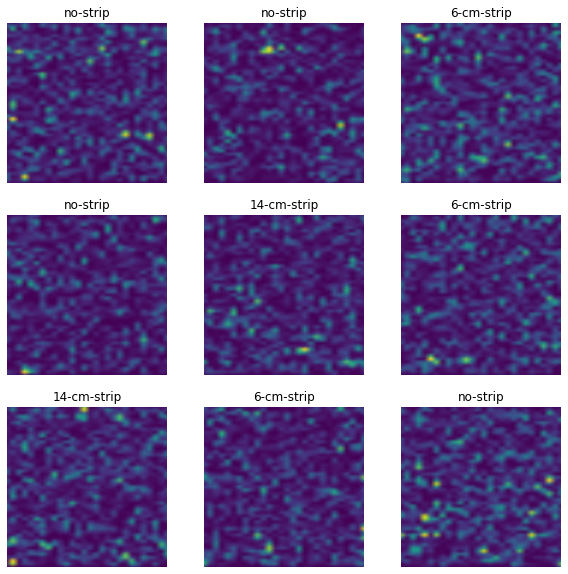

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# # image_batch, labels_batch = next(iter(normalized_ds))
# # first_image = image_batch[0]
# # # Notice the pixel values are now in `[0,1]`.
# # print(np.min(first_image), np.max(first_image))

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [ ]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
#                 num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
#                 num_parallel_calls=AUTOTUNE)

In [ ]:
# train_ds = train_ds.shuffle(50)

In [ ]:
num_classes = 3

## MODEL TF
# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

# # # MODEL LENET
# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(filters=8, kernel_size=(5,5), activation='tanh', input_shape=(img_height, img_width, num_channels)),
#   tf.keras.layers.AveragePooling2D(2),
#   # tf.keras.layers.Activation('relu'),
#   tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='tanh'),
#   tf.keras.layers.AveragePooling2D(2),
#   # tf.keras.layers.Activation('relu'),
#   tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='tanh'),
#   tf.keras.layers.AveragePooling2D(2),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
#     tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# # # MODEL KAGGLE
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    # tf.keras.layers.RandomRotation(0.2),
    #first_convolution
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(img_height, img_width, num_channels)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # #third_convolution
    tf.keras.layers.Conv2D(64, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # #fourth_convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation('softmax'),
])

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Rescaling(1./255),
#     #first_convolution
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     #second_convolution
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     #third_convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     #fourth_convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
model.compile(
  optimizer='SGD',
  # optimizer=tf.keras.optimizers.Adam(learning_rate=10E-6),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  # loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:

from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_ds), y=train_ds)
max_count_class = np.max([count_14cm_strip, count_6cm_strip, count_nostrip])

class_weights = {
    class_names.index('14-cm-strip'): max_count_class / count_14cm_strip,
    class_names.index('6-cm-strip'): max_count_class / count_6cm_strip,
    class_names.index('no-strip'): max_count_class / count_nostrip
}

# class_weights = {
#     class_names.index('14-cm-strip'): count / (count_14cm_strip * num_classes),
#     class_names.index('6-cm-strip'): count / (count_6cm_strip * num_classes),
#     class_names.index('no-strip'): count / (count_nostrip * num_classes)
# }

print(class_weights)

{0: 1.0722222222222222, 1: 1.0, 2: 1.0432432432432432}


In [ ]:
es=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=3,
                                     verbose=1,  restore_best_weights=True)
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1,
                                             verbose=1)
callback_list=[es, rlronp]

In [ ]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # steps_per_epoch=176//32,
    # validation_steps=9//32,
    batch_size=32,
    # class_weight=class_weights,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)
    # callbacks=callback_list
)

Epoch 1/50
16/16 [==============================] - 10s 587ms/step - loss: 1.1071 - accuracy: 0.3141 - val_loss: 1.0989 - val_accuracy: 0.3704
Epoch 2/50
16/16 [==============================] - 9s 573ms/step - loss: 1.0977 - accuracy: 0.3519 - val_loss: 1.0987 - val_accuracy: 0.3704
Epoch 3/50
16/16 [==============================] - 9s 571ms/step - loss: 1.0984 - accuracy: 0.3479 - val_loss: 1.0988 - val_accuracy: 0.3704
Epoch 4/50
16/16 [==============================] - 9s 574ms/step - loss: 1.0961 - accuracy: 0.3579 - val_loss: 1.0974 - val_accuracy: 0.3704
Epoch 5/50
16/16 [==============================] - 9s 577ms/step - loss: 1.0970 - accuracy: 0.3439 - val_loss: 1.0982 - val_accuracy: 0.3704
Epoch 6/50
16/16 [==============================] - 9s 575ms/step - loss: 1.0935 - accuracy: 0.3459 - val_loss: 1.0986 - val_accuracy: 0.4074
Epoch 7/50
16/16 [==============================] - 9s 588ms/step - loss: 1.0921 - accuracy: 0.3956 - val_loss: 1.0981 - val_accuracy: 0.4074
Epoch

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 activation_72 (Activation)  (None, 148, 148, 16)      0         
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 activation_73 (Activation)  (None, 72, 72, 32)        0         
                                                     

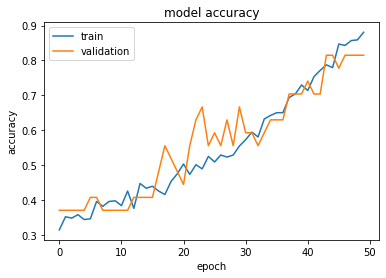

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

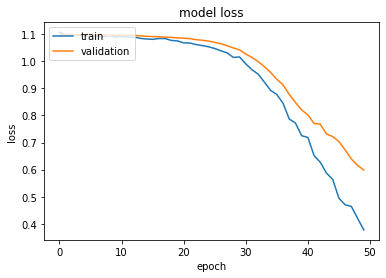

In [ ]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(val_ds)

1/1 [==============================] - 0s 165ms/step - loss: 0.5987 - accuracy: 0.8148


In [ ]:
print('Model accuracy', accuracy[1])

Model accuracy 0.8148148059844971


### Predicting

In [ ]:
predictions = model.predict(test_ds)

1/1 [==============================] - 1s 1s/step


In [ ]:
print(predictions[0])
predicted_label_id = np.argmax(predictions[0])
print(class_names[predicted_label_id])

[0.31730458 0.34216073 0.3405347 ]
6-cm-strip


### Confusion Matrix

n Test_Accuracy:- 0.8148148059844971
confusion matrix
[[7 1 2]
 [0 6 1]
 [1 3 7]]


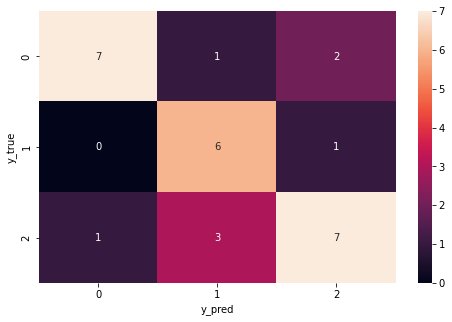

In [ ]:
print('n', 'Test_Accuracy:-', accuracy[1])
y_pred = np.argmax(predictions, axis=1)
# y_true = np.argmax(predictions, axis=1)
y_true = list(test_ds)[0][1]
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()